In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)  # para visualizar todas las columnas de los DataFrames

# Gestión de warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore  # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor  # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest  # para detectar outliers usando el método IF
from sklearn.neighbors import NearestNeighbors  # para calcular la epsilon
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder # TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder
from category_encoders import TargetEncoder
# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations

# Importación de las clases creadas en nuestro archivo de soporte
# -----------------------------------------------------------------------
from src import soporte_preprocesamiento as sp
from src import soporte_outliers as so
from src import soporte_encoding as se


In [2]:
df = pd.read_csv("datos/datos_limpios.csv", index_col = 0)

In [3]:
df.head()

,price,propertyType,size,exterior,rooms,bathrooms,municipality,latitude,longitude,showAddress,distance,hasVideo,status,hasPlan,has3DTour,has360,floor,hasLift
0,750.0,flat,60.0,True,1,1,Madrid,40.464616,-3.648918,True,7037,False,good,False,False,False,3,True
1,750.0,flat,70.0,True,2,1,San Sebastián de los Reyes,40.550086,-3.627808,False,16145,True,good,True,False,False,bj,False
2,400.0,penthouse,67.0,True,2,2,Villamanrique de Tajo,40.069197,-3.241383,False,55041,False,good,False,False,True,2,False
3,590.0,flat,70.0,True,3,2,Rascafría,40.907397,-3.881600,False,56596,False,good,False,False,False,desconocido,False
4,684.0,studio,45.0,True,0,1,Madrid,40.485527,-3.615598,True,10656,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 0 to 352
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         353 non-null    float64
 1   propertyType  353 non-null    object 
 2   size          353 non-null    float64
 3   exterior      353 non-null    bool   
 4   rooms         353 non-null    int64  
 5   bathrooms     353 non-null    int64  
 6   municipality  353 non-null    object 
 7   latitude      353 non-null    float64
 8   longitude     353 non-null    float64
 9   showAddress   353 non-null    bool   
 10  distance      353 non-null    int64  
 11  hasVideo      353 non-null    object 
 12  status        353 non-null    object 
 13  hasPlan       353 non-null    object 
 14  has3DTour     353 non-null    object 
 15  has360        353 non-null    object 
 16  floor         353 non-null    object 
 17  hasLift       353 non-null    object 
dtypes: bool(2), float64(4), int64(3), o

In [4]:
df[df.select_dtypes("bool").columns] = df.select_dtypes("bool").astype("str")

In [5]:
df[["rooms", "bathrooms"]] = df[["rooms", "bathrooms"]].astype("str")

In [6]:
columnas_mumericas = df.select_dtypes("number").columns
columnas_categoricas = df.select_dtypes("O").columns

In [7]:
df[columnas_mumericas].info()

<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 0 to 352
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      353 non-null    float64
 1   size       353 non-null    float64
 2   latitude   353 non-null    float64
 3   longitude  353 non-null    float64
 4   distance   353 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 16.5 KB


Eliminamos latitud y longitud, pues dado que no vamos a imputar nulos en las categorias numericas, la información de localización que necesitamos nos la dan distnace y municipality, y columnas como latitude y longitude que tienen todos sus valores como unicos carecen de relevancia para el análisis predictivo

In [8]:
df.drop(columns = ["latitude", "longitude"], inplace=True)

In [9]:
df[columnas_categoricas].head()

,propertyType,exterior,rooms,bathrooms,municipality,showAddress,hasVideo,status,hasPlan,has3DTour,has360,floor,hasLift
0,flat,True,1,1,Madrid,True,False,good,False,False,False,3,True
1,flat,True,2,1,San Sebastián de los Reyes,False,True,good,True,False,False,bj,False
2,penthouse,True,2,2,Villamanrique de Tajo,False,False,good,False,False,True,2,False
3,flat,True,3,2,Rascafría,False,False,good,False,False,False,desconocido,False
4,studio,True,0,1,Madrid,True,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido


In [10]:
df[columnas_categoricas].info()

<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 0 to 352
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   propertyType  353 non-null    object
 1   exterior      353 non-null    object
 2   rooms         353 non-null    object
 3   bathrooms     353 non-null    object
 4   municipality  353 non-null    object
 5   showAddress   353 non-null    object
 6   hasVideo      353 non-null    object
 7   status        353 non-null    object
 8   hasPlan       353 non-null    object
 9   has3DTour     353 non-null    object
 10  has360        353 non-null    object
 11  floor         353 non-null    object
 12  hasLift       353 non-null    object
dtypes: object(13)
memory usage: 38.6+ KB


In [11]:
# Creamos una lista con las columnas categóricas
lista_col_categ = columnas_categoricas.tolist()
lista_col_categ

['propertyType',
 'exterior',
 'rooms',
 'bathrooms',
 'municipality',
 'showAddress',
 'hasVideo',
 'status',
 'hasPlan',
 'has3DTour',
 'has360',
 'floor',
 'hasLift']

Generamos unas visualizaciones (barplot y boxplot) de como se distribuye cada variable categórica respuesto a la variable respuesta

In [72]:
# Instanciamos la clase de Encoding
analisis_encoding = se.Analisis_Visual_Encoding(variable_respuesta="price", dataframe=df, lista_variables_categorias=lista_col_categ)



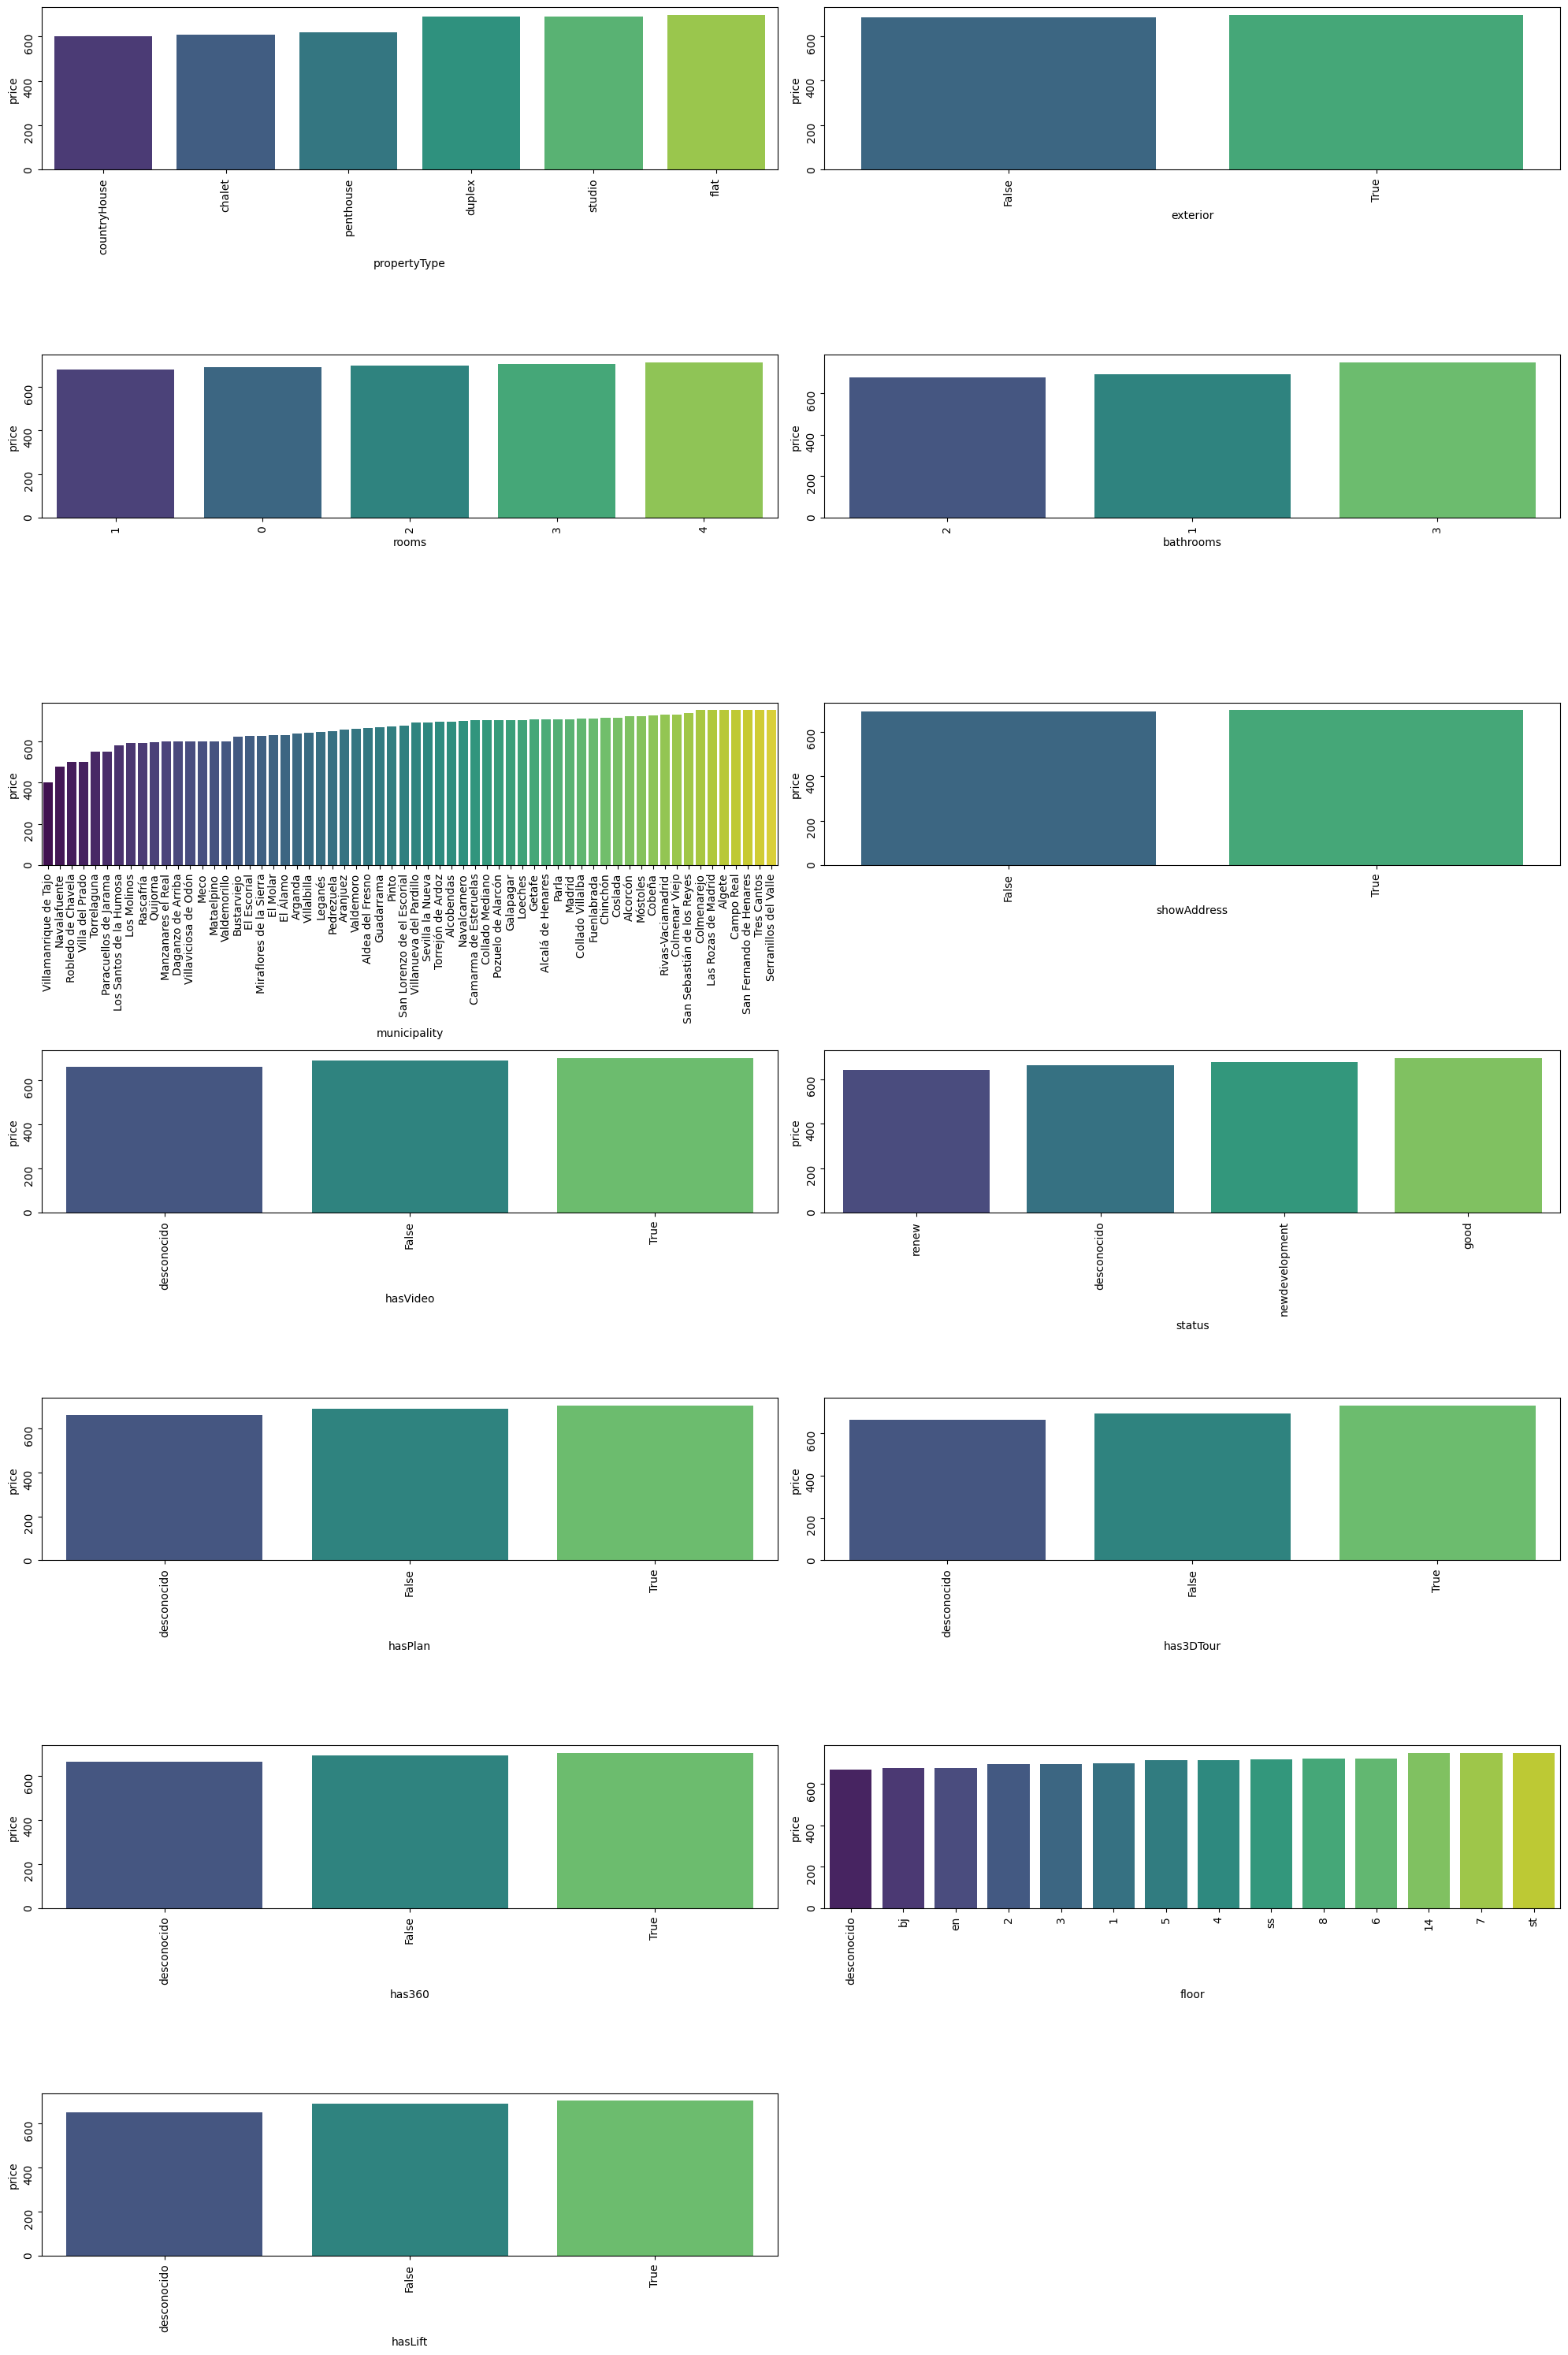

In [14]:
analisis_encoding.crear_barplot(tamano_grafica=(20, 30))

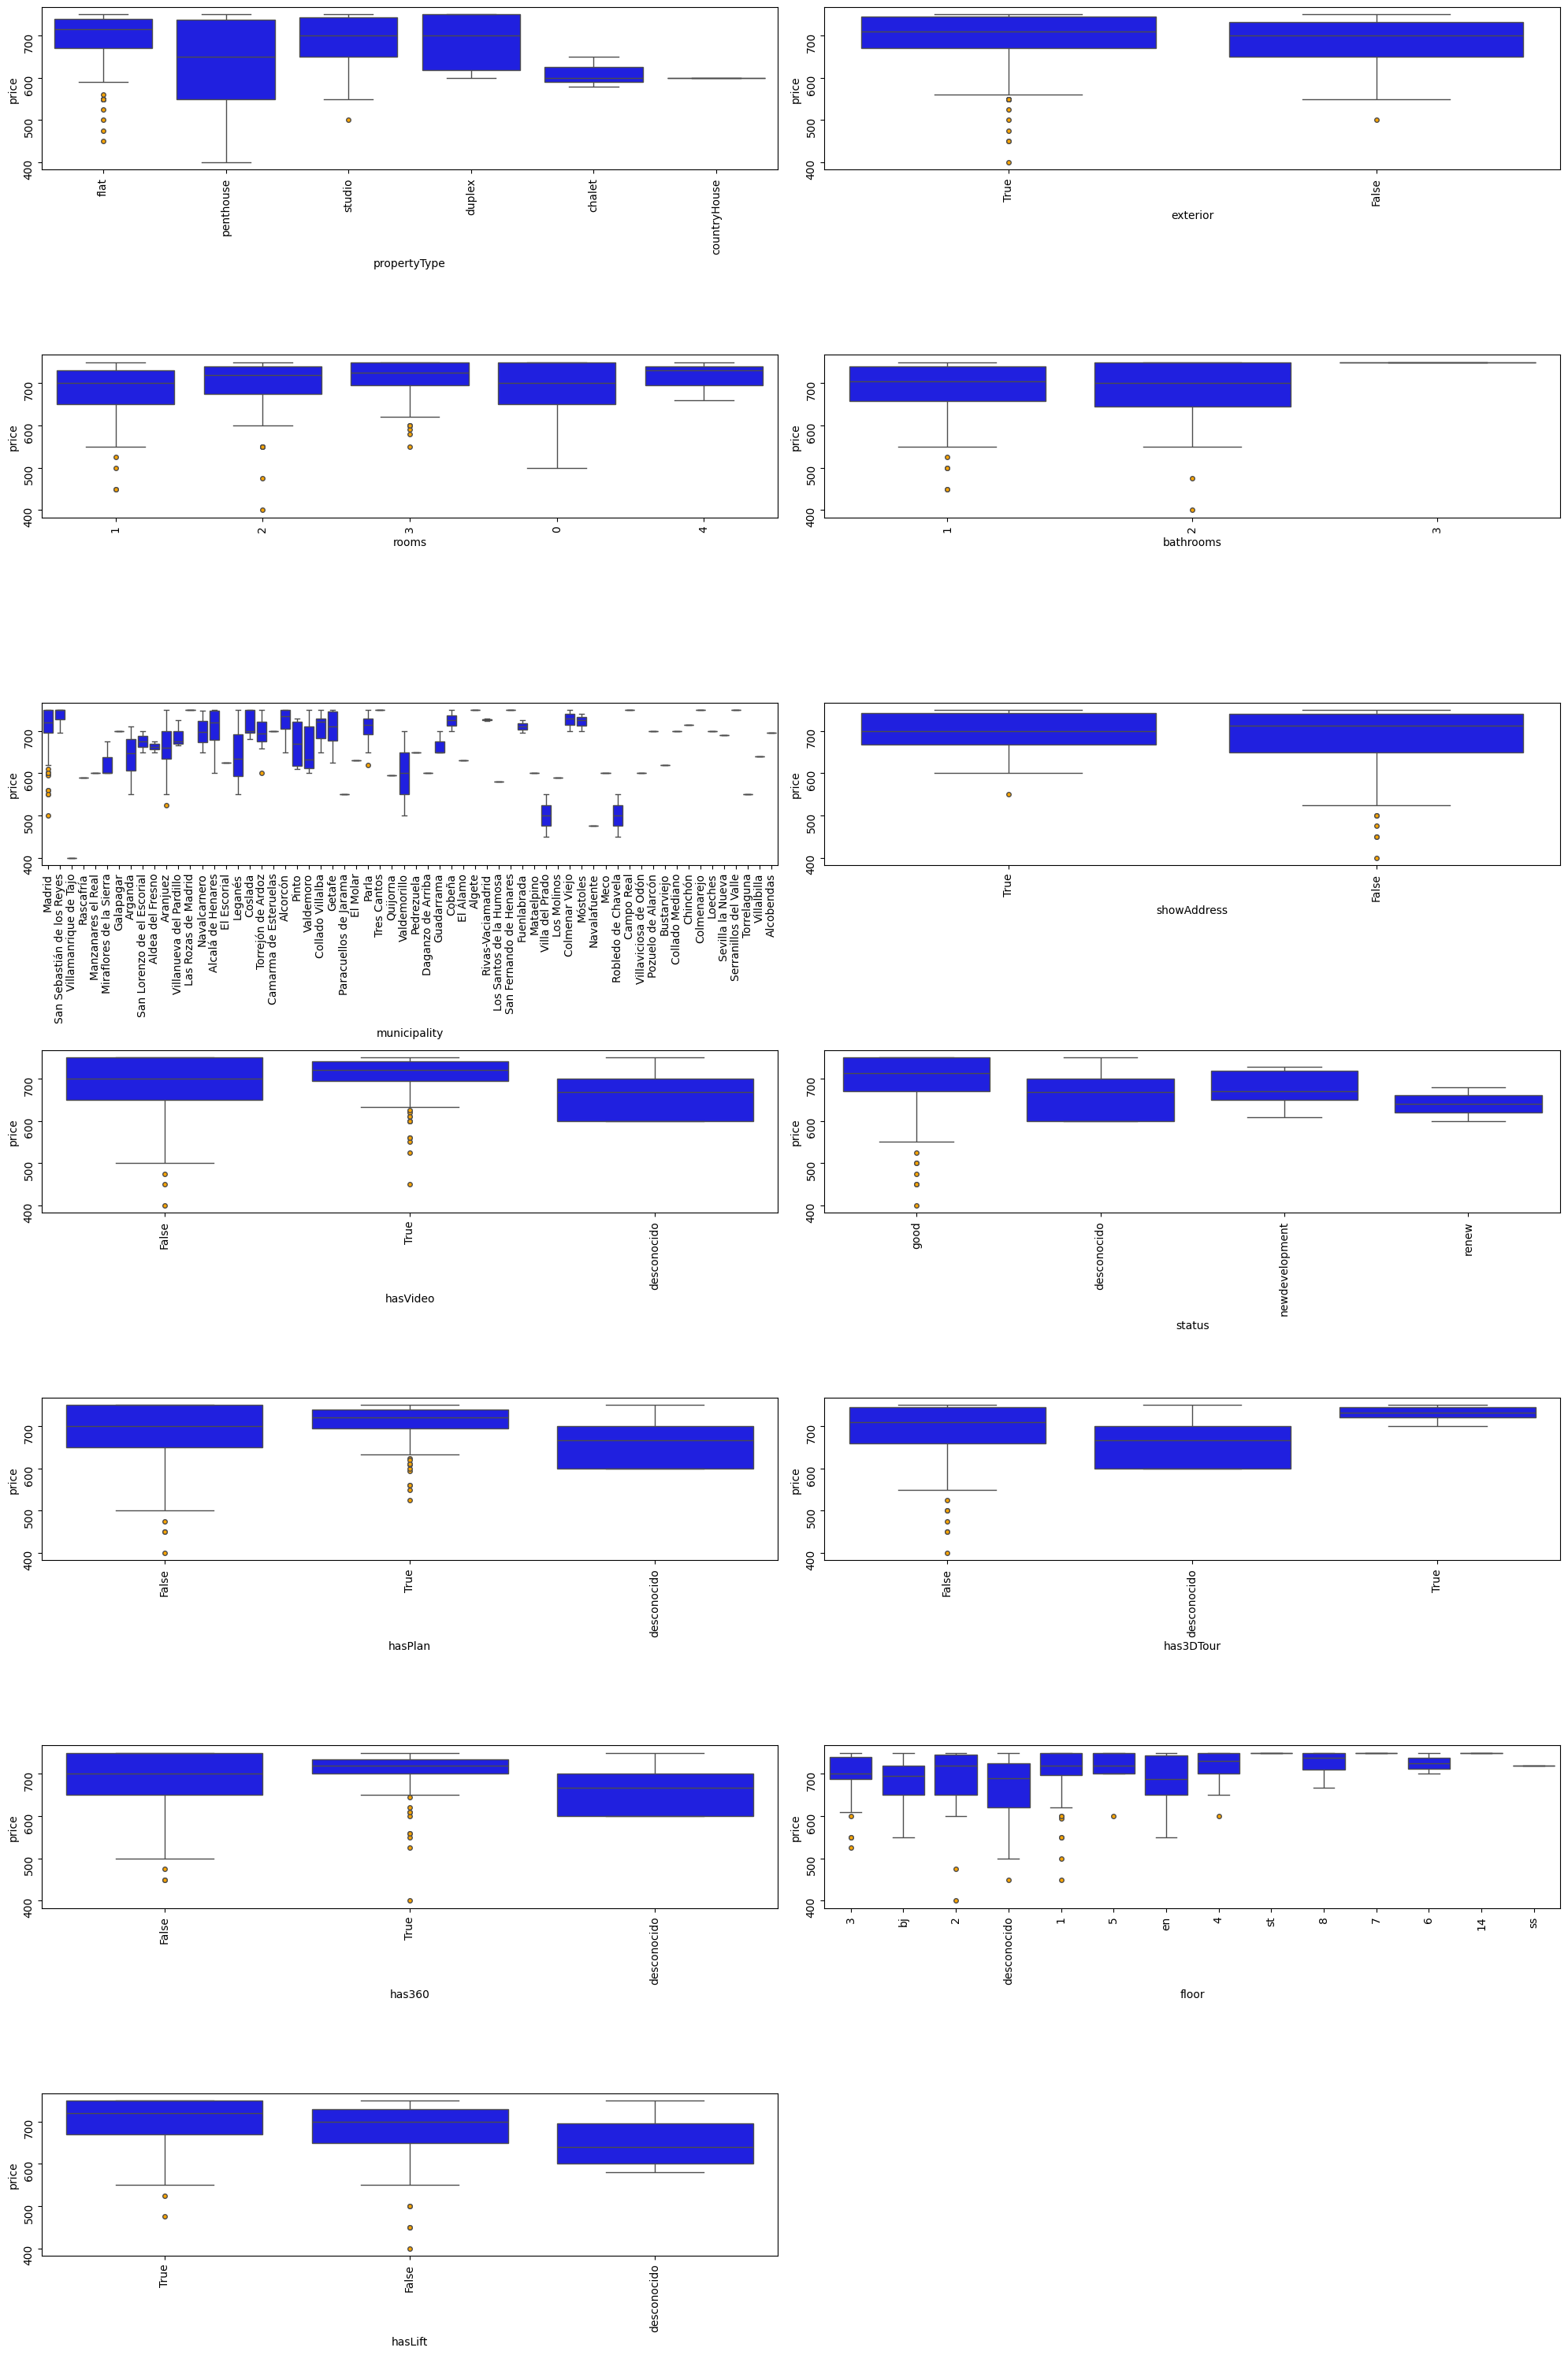

In [15]:
analisis_encoding.crear_boxplot(tamano_grafica=(20, 30))

A la luz de las gráficas anteriores no hay normalidad, y todas las variables son de tres o más categorías, así que en la fase de encoding que viene a continuación, cuándo hagaos el test A/B elegiremos el método de Matt-Whitney o el de kruskal.

### Encoding

Hacemos el test A/B para ver que columnas son ordinales

In [16]:
# instanciamos la clase de Asunciones, para poder decidir qué método usar para el análisis estadístico
asunciones = se.Asunciones(dataframe = df, columna_numerica = "price")

In [17]:
for categoria in lista_col_categ:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    # comprobamos la asunción de normalidad
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = se.TestEstadisticos(df, "price", categoria)
    test.run_all_tests()
    print("\n###########################\n")

Estamos analizando la variable PROPERTYTYPE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable propertyType las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['flat', 'penthouse', 'studio', 'duplex', 'chalet', 'countryHouse']



Realizando test de Kruskal...
Estadístico de prueba: 10.491276765664804
Valor p: 0.062453362538402654
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
12,-77.6596,0.0009,-132.6632,-22.6560,flat-penthouse
14,69.7250,0.0110,10.3254,129.1246,penthouse-studio



###########################

Estamos analizando la variable EXTERIOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable exterior las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False']

Realizando test de Mannwhitneyu...
Estadístico del Test de Mann-Whitney U: 10691.5
Valor p: 0.18180926288442967
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable ROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable rooms las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3', '0', '4']

Realizando test de Kruskal...
Estadístico de prueba: 6.997445029790361
Valor p: 0.13602330549397834
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable BATHROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable bathrooms las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3']

Realizando test de Kruskal...
Estadístico de prueba: 2.17914787981004
Valor p: 0.3363597726585303
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable MUNICIPALITY
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable municipality las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Madrid', 'San Sebastián de los Reyes', 'Villamanrique de Tajo', 'Rascafría', 'Manzanares el Real', 'Miraflores de la Sierra', 'Galapagar', 'Arganda', 'San Lorenzo de el Escorial', 'Aldea del Fresno', 'Aranjuez', 'Villanueva del Pardillo', 'Las Rozas de Madrid', 'Navalcarnero', 'Alcalá de Henares', 'El Escorial', 'Leganés', 'Coslada', 'Torrejón de Ardoz', 'Camarma de Esteruelas', 'Alcorcón', 'Pinto', 'Valdemoro', 'Collado Villalba', 'Getafe', 'Paracuellos de Jarama', 'El Molar', 'Parla', 'Tres Cantos', 'Quijorna', 'Valdemorillo', 'Pedrezuela', 'Daganzo de Arriba', 'Guadarrama', 'Cobeña', 'El Álamo', 'Algete', 'Rivas-Vaciamadrid', 'Los Santos de la Humosa', 'San Fernando de Henares', 'Fuenlabrada', 'Mata

,meandiff,p-adj,lower,upper,group_diff
35,-230.0909,0.0100,-438.6427,-21.5391,Alcalá de Henares-Navalafuente
45,-205.0909,0.0001,-355.7310,-54.4508,Alcalá de Henares-Robledo de Chavela
56,-205.0909,0.0001,-355.7310,-54.4508,Alcalá de Henares-Villa del Prado
58,-305.0909,0.0000,-513.6427,-96.5391,Alcalá de Henares-Villamanrique de Tajo
118,-295.0000,0.0359,-583.4538,-6.5462,Alcobendas-Villamanrique de Tajo
...,...,...,...,...,...
1865,-250.0000,0.0011,-453.9677,-46.0323,Tres Cantos-Villa del Prado
1867,-350.0000,0.0000,-599.8083,-100.1917,Tres Cantos-Villamanrique de Tajo
1878,-261.0000,0.0019,-479.0506,-42.9494,Valdemoro-Villamanrique de Tajo
1883,188.6667,0.0413,2.4705,374.8628,Villa del Prado-Villanueva del Pardillo



###########################

Estamos analizando la variable SHOWADDRESS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable showAddress las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False']

Realizando test de Mannwhitneyu...
Estadístico del Test de Mann-Whitney U: 11153.5
Valor p: 0.6107451714725374
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable HASVIDEO
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable hasVideo las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'True', 'desconocido']

Realizando test de Kruskal...
Estadístico de prueba: 7.246281499386718
Valor p: 0.026698690767764828
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable STATUS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable status las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['good', 'desconocido', 'newdevelopment', 'renew']

Realizando test de Kruskal...
Estadístico de prueba: 11.541040965775425
Valor p: 0.009132723494666343
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable HASPLAN
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable hasPlan las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'True', 'desconocido']

Realizando test de Kruskal...
Estadístico de prueba: 7.183821049179696
Valor p: 0.027545653470666565
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,16.6962,0.0429,0.4164,32.9760,False-True
2,-42.6477,0.0355,-83.0093,-2.2861,True-desconocido



###########################

Estamos analizando la variable HAS3DTOUR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable has3DTour las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'desconocido', 'True']

Realizando test de Kruskal...
Estadístico de prueba: 6.286194629856895
Valor p: 0.04314894484542267
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable HAS360
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable has360 las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'True', 'desconocido']

Realizando test de Kruskal...
Estadístico de prueba: 5.752988674847895
Valor p: 0.056331897713708286
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable FLOOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable floor las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['3', 'bj', '2', 'desconocido', '1', '5', 'en', '4', 'st', '8', '7', '6', '14', 'ss']

Realizando test de Kruskal...
Estadístico de prueba: 31.48890585086721
Valor p: 0.002858350329048415
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
51,-45.4949,0.0329,-89.2619,-1.728,4-desconocido



###########################

Estamos analizando la variable HASLIFT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable hasLift las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False', 'desconocido']

Realizando test de Kruskal...
Estadístico de prueba: 13.627872283280148
Valor p: 0.0010983610754482008
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
1,-37.4113,0.0345,-72.6565,-2.1662,False-desconocido
2,-52.0307,0.0016,-87.1432,-16.9181,True-desconocido



###########################



A la vista del test anterior concluimos que son:

**Variables ordenadas:**

    - MUNICIPALITY

    - HASVIDEO

    - STATUS
    
    - HASPLAN

    - HAS3DTOUR

    - FLOOR

    - HASLIFT

**Variables no ordenadas:**

    - PROPERTYTYPE

    - EXTERIOR

    - ROOMS
    
    - BATHROOMS

    - SHOWADDRESS
    
    - HAS360
    


Definimos el diccionario que almacena el tipo de encoding que recibirá cada columna

In [12]:
diccionario_encoding = {"onehot": ["propertyType", "exterior", "rooms", "bathrooms", "showAddress", "has360"], 
                        "dummies": [], # no metemos ninguna
                        'ordinal' : { }, #no metemos ninguna
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ["municipality", "hasVideo", "status","hasPlan", "has3DTour", "floor", "hasLift"]  
                        }

In [13]:
# Hacemos el one_hot_encoding
encoding = se.Encoding(df, diccionario_encoding, "price")
df_one_hot= encoding.one_hot_encoding()
df_one_hot.head()

,price,propertyType,size,exterior,rooms,bathrooms,municipality,showAddress,distance,hasVideo,status,hasPlan,has3DTour,has360,floor,hasLift,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,bathrooms_1,bathrooms_2,bathrooms_3,showAddress_False,showAddress_True,has360_False,has360_True,has360_desconocido
0,750.0,flat,60.0,True,1,1,Madrid,True,7037,False,good,False,False,False,3,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,750.0,flat,70.0,True,2,1,San Sebastián de los Reyes,False,16145,True,good,True,False,False,bj,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,400.0,penthouse,67.0,True,2,2,Villamanrique de Tajo,False,55041,False,good,False,False,True,2,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,590.0,flat,70.0,True,3,2,Rascafría,False,56596,False,good,False,False,False,desconocido,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,684.0,studio,45.0,True,0,1,Madrid,True,10656,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,desconocido,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
encoder_target= TargetEncoder(cols=["municipality", "hasVideo", "status","hasPlan", "has3DTour", "floor", "hasLift"])
df_encoded= encoder_target.fit_transform(df_one_hot , df_one_hot[["price"]])
lista_eliminar=["propertyType", "exterior", "rooms", "bathrooms", "showAddress", "has360"]
df_encoded.drop(columns=lista_eliminar, inplace=True)
df_encoded.head()

,price,size,municipality,distance,hasVideo,status,hasPlan,has3DTour,floor,hasLift,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,bathrooms_1,bathrooms_2,bathrooms_3,showAddress_False,showAddress_True,has360_False,has360_True,has360_desconocido
0,750.0,60.0,705.594114,7037,690.308696,695.243827,688.380091,693.661677,697.689843,702.252872,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,750.0,70.0,701.418584,16145,702.384032,695.243827,705.075598,693.661677,678.664014,687.633544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,400.0,67.0,654.819074,55041,690.308696,695.243827,688.380091,693.661677,696.092223,687.633544,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,590.0,70.0,679.539684,56596,690.308696,695.243827,688.380091,693.661677,670.416613,687.633544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,684.0,45.0,705.594114,10656,682.123310,682.123310,682.123310,682.123310,670.416613,673.705516,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [15]:
df_encoded.to_csv("datos/datos_encoding.csv")